# Лабораторная работа № 3 - Нечёткая логика и нечёткие регуляторы

В данной работе нам предстоит создать агента, использующего нечёткую логику для управления динамической системой. В качестве "подопытной" динамической системы используется классическая задача "тележка со стержнем". На тележке, которая может перемещаться в горизонтальном направлении, закреплен стержень, который в начальный момент времени имеет почти вертикальное положение. Очевидно, под действием силы тяжести стержень начинает падать. Падение может быть предотвращено перемещением тележки путем приложения к ней силы (вправо или влево, в зависимости от того, в какую сторону наклоняется стержень). Задачей агента является поддержание вертикального положения стержня.

Для разработки и отладки различных алгоритмов управления динамическими системами широко применяются имитаторы. В этой лабораторной работе для имитации системы "тележка со стержнем" мы будем применять библиотеку Gymnasium (ранее OpenAI Gym) - эта библиотека широко используется при исследовании различных алгоритмов управления и обучения с подкреплением. Многие известные бенчмарки в данной области уже реализованы в Gymnasium, в том числе и "тележка со стержнем", однако мы будем использовать слегка модифицированную версию, в которой к тележке в каждый момент можно прикладывать заданую силу (а не фиксированную).

In [1]:
import gymnasium as gym

import math
import random

In [2]:
# Загрузим модифицированную версию имитатора тележки со стержнем
from continuous_cartpole import ContinuousCartPoleEnv

## Демонстрация имитатора

Одной из очень удобных особенностей Gymnasium является поддержка разных режимов отображения моделируемой системы. В частности, это позволяет визуально оценить поведение системы при том или ином управлении, используя наглядную анимацию. Выбор режима отображения осуществляется с помощью параметра `render_mode` конструктора (для отображения анимации следует передать значение `'human'` - впрочем, нужно иметь в виду, что анимированная визуализация не обязательна, окружения могут и не поддерживать ее).

In [3]:
env = ContinuousCartPoleEnv(render_mode='human')

Отобразим динамику поведения стержня при отсутствии управления. Взаимодействие с моделью системы (окружением) организовано по шагам - на каждом шаге (функция `step`) необходимо передать управление. Функция возвращает кортеж значений, среди которых признак остановки. Эпизод моделирования стержня заканчивается, когда он отклоняется более чем на 20 градусов от вертикали. Отсутствие управления означает передачу нулевого воздействия на каждом шаге:

In [4]:
observation, info = env.reset()

for _ in range(1000):
    observation, reward, terminated, truncated, info = env.step((0.0,))

    if terminated or truncated:
        break

env.close()

E:\opt\Miniconda3\envs\aim\lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


Видно, что без управления стержень достаточно быстро падает.

## Несколько простых агентов

Реализуем несколько простых агентов и функцию оценки (метрику), по которой будем сравнивать эффективность алгоритмов управления. В качестве такой функции оценки удобно использовать количество падений стержня за определенное, достаточно большое, количество шагов или статистические характеристики отклонения стержня от вертикали.


In [5]:
class NoOpAgent:

    def get_action(self, obs):
        return (0.0, )

class RandomAgent:

    def get_action(self, obs):
        return (random.random() * 2 - 1, )

def to_grad(x : float) -> float:
    return x * 180 / math.pi

def run(env, agent, n=10000):
    """Запускает имитацию заданного агента в заданном окружении.

    Имитация продолжается в `n` шагов. При падении стержня - перезапускается.
    Результатом работы является количество падений и временной ряд абсолютных
    отклонений стержня от вертикали (в градусах)."""

    fell = 0
    angles = []
    
    observation, info = env.reset()
    angles.append(to_grad(abs(observation[2])))
    
    for _ in range(n):
        action = agent.get_action(observation) # env.action_space.sample()  # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        angles.append(to_grad(abs(observation[2])))
    
        if terminated or truncated:
            observation, info = env.reset()
            fell += 1

    return fell, angles


In [6]:
for agent_name, agent in [('NoOp agent', NoOpAgent()),
                          ('Random agent', RandomAgent())]:
    env = ContinuousCartPoleEnv()
    n_fell, angles = run(env, agent, 10000)
    env.close()
    print(f'{agent_name}: {n_fell} падений')

NoOp agent: 210 падений
Random agent: 302 падений


Случайным образом дергающий тележку агент показывает худший показатель, чем не трогающий ее вообще.

## Управление на основе строгих правил

Было бы достаточно наивно ожидать от простейших агентов выше какого-то хорошего результата - в конце-концов, они никак не использовали информацию о текущем положении стержня. Более разумным "бейзлайном" будет агент, прикладывающий то или иное воздействие в зависимости от состояния стержня. Информация об этом состоянии содержится в первом элементе, возвращаемом функцией `step` (который присваивается в переменную `observation` в коде выше). Это состояние, в свою очередь, является вектором из 4 элементов:

- позиция тележки [-4.8; 4.8];
- скорость тележки (положительная, если она едет вправо, отрицательная, если влево);
- угол наклона стержня, в радианах [-0.4 (-24°); 0.4 (24°)];
- угловая скорость стержня.

Например, разумным подходом будет толкать тележку в ту сторону, в которую она отклонилась, если это отклонение достаточно велико.

In [7]:
class SimpleRuleBasedAgent:
    """Управление системой "тележка-стержень" на основе положения стержня.

    Если наклон стержня (в какую-либо сторону) превышает 5°, то толкнуть
    тележку в эту сторону с силой 0.2.
    """
    def __init__(self):
        self.threshold_grad = 5
        self.push_force = 0.2
    
    def get_action(self, obs):
        x, v_x, angle, v_angle = obs
        if abs(to_grad(angle)) > self.threshold_grad:
            if angle > 0: return (self.push_force, )
            else:         return (-self.push_force, )
        else:
            return (0.0, )


In [8]:
env = ContinuousCartPoleEnv()
agent = SimpleRuleBasedAgent()
n_fell, angles = run(env, agent, 10000)
env.close()
print('Rule-based agent', n_fell)

Rule-based agent 66


Видно, что количество падений за 10000 шагов стало гораздо меньше. Отобразим поведение системы при заданном управлении.

In [9]:
env = ContinuousCartPoleEnv(render_mode='human')
agent = SimpleRuleBasedAgent()
n_fell, angles = run(env, agent, 1000)
env.close()

**Задание 1**: Попробуйте настроить параметры `SimpleRuleBasedAgent`, чтобы снизить количество падений.

## Нечёткий регулятор

Для реализации нечёткого регулятора воспользуемся библиотекой `scikit-fuzzy`, предоставляющий обширный набор средств для построения нечётких систем - различные типовые функции принадлежности, операции над нечёткими множествами, алгоритмы вывода и пр. В относительно свежих версиях этой библиотеки предусмотрено два уровня API - низкоуровневый, в котором буквально все можно (и приходится) контролировать программисту, и высокоуровневый (в пакете `skfuzzy.control`), которым мы и воспользуемся.

In [10]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

Модель программирования нечётких регуляторов, предлагаемая `skfuzzy.control`, требует, чтобы все линвистические переменные были разделены на два
подмножества - антецеденты (то, что будет использоваться в *антецеденте* правила, части *ЕСЛИ*) и консеквенты (то, что будет использоваться
в *консеквенте* правил, части *ТО*).

В случае со стержнем переменные-антецеденты будут соответствовать наблюдаемым характеристикам системы, а переменная-консеквент - управляющему воздействию.

In [11]:
# Угол наклона стержня
angle = ctrl.Antecedent(np.arange(-30, 30, 0.1), 'angle')

angle['LLL'] = fuzz.trapmf(angle.universe, [-30, -30, -15, -10])
angle['LL']  = fuzz.trimf(angle.universe, [-15, -10, -5])
angle['L']   = fuzz.trimf(angle.universe, [-10, -5, 0])
angle['N']   = fuzz.trimf(angle.universe, [-5, 0, 5])
angle['R']   = fuzz.trimf(angle.universe, [0, 5, 10])
angle['RR']  = fuzz.trimf(angle.universe, [5, 10, 15])
angle['RRR'] = fuzz.trapmf(angle.universe, [10, 15, 30, 30])

E:\opt\Miniconda3\envs\aim\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


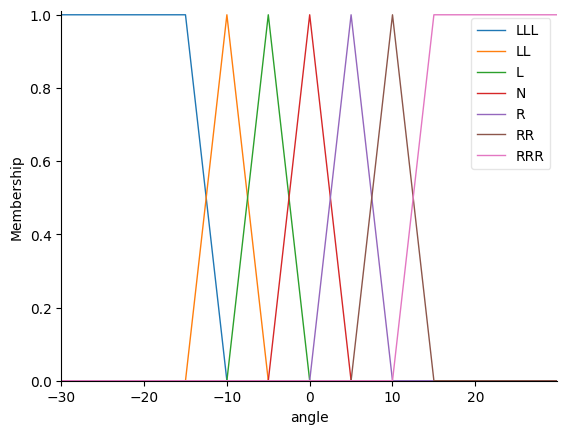

In [12]:
angle.view()

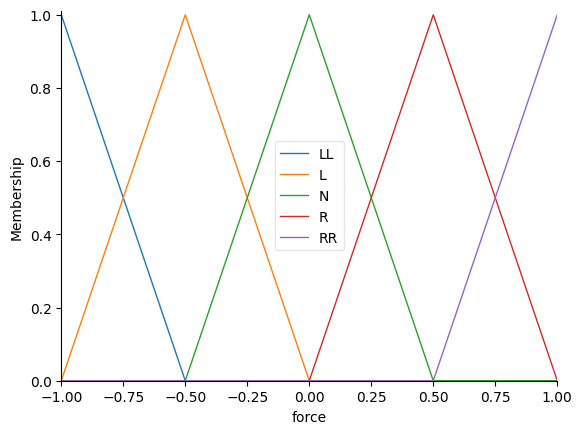

In [13]:
# Управляющее воздействие (сила, прикладываемая к тележке)
force = ctrl.Consequent(np.linspace(-1, 1, 21), 'force')
# Автоматическое создание нечётких множеств типовой формы
force.automf(5, names=['LL', 'L', 'N', 'R', 'RR'])
force.view()

Определим правила, по которым будет выбираться управляющее воздействие:

In [14]:
rule1 = ctrl.Rule(angle['LLL'] | angle['LL'], force['LL'])
rule2 = ctrl.Rule(angle['L'], force['L'])
rule3 = ctrl.Rule(angle['N'], force['N'])
rule4 = ctrl.Rule(angle['R'], force['R'])
rule5 = ctrl.Rule(angle['RRR'] | angle['RR'], force['RR'])

Наконец, соберем управляющий алгоритм, определяемый этим набором правил:

In [15]:
cartpole_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
cartpole_sim = ctrl.ControlSystemSimulation(cartpole_ctrl)

Проверим поведение регулятора на некоторых входных значениях:

In [16]:
# Задаем значения всех переменных-входов (переменных-антецедентов)
cartpole_sim.input['angle'] = -10.0
# Запускаем вывод
cartpole_sim.compute()
# Отображаем результат
cartpole_sim.output

OrderedDict([('force', -0.833333333333264)])

В целях отладки можно и визуализировать проведенный вывод:

-0.833333333333264


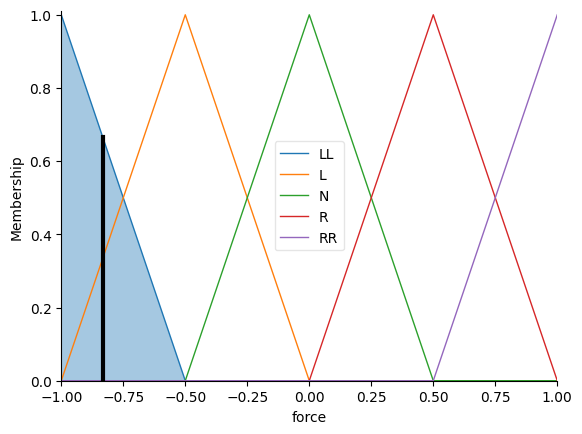

In [17]:
print(cartpole_sim.output['force'])
force.view(sim=cartpole_sim)

Еще очень интересно может быть визуализировать зависимость управляющего воздействия от наблюдаемых значений (это не всегда возможно из-за большой размерности входного пространства признаков, но в данной постановке - вполне).

In [18]:
import matplotlib.pyplot as plt

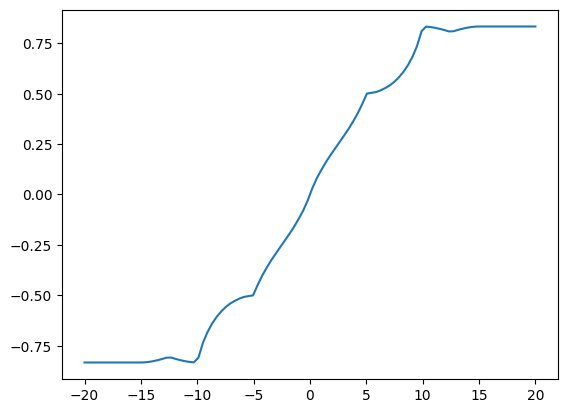

In [19]:
x = np.linspace(-20, 20, 100)
y = []
for c_x in x:
    cartpole_sim.input['angle'] = c_x
    cartpole_sim.compute()
    y.append(cartpole_sim.output['force'])
y = np.array(y)

plt.plot(x, y)

**Задание 2.** Закончите реализацию нечетко-логического агента для управления стержнем (см. код ниже). Оцените качество управления и визуализируйте поведение стержня под получившимся управляющим воздействием.

In [20]:
class FuzzyAgent:

    def __init__(self):

        # ВСТАВЬТЕ СЮДА КОД ДЛЯ ОПРЕДЕЛЕНИЯ
        # РЕГУЛЯТОРА (переменные, правила, и т.п.)
        self.controller = None  # ЗАМЕНИТЕ None
    
    def get_action(self, obs):
        # x - координата тележки
        # v_x - скорость тележки
        # angle - угол наклона стержня в радианах
        # v_angle - угловая скорость стержня
        x, v_x, angle, v_angle = obs

        # ВСТАВЬТЕ СЮДА КОД ДЛЯ ВЫБОРА
        # ДЕЙСТВИЯ НА ОСНОВЕ НАБЛЮДЕНИЯ

        force = 0  # ЗАМЕНИТЕ 0 
        return (force, )


**Задание 3.** Усовершенствуйте систему правил, добавив к анализу угловую скорость стержня (и, возможно, по-другому определив переменные), чтобы количество падений за 10000 шагов не превышало 10.